## 1. Import libraries

In [1]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm 
import os
import warnings

warnings.filterwarnings("ignore")

plt.style.use('fivethirtyeight')

In [2]:
#create file path and import dataset
path = r'C:\Users\krist\ATX Metro Bike\02.Data'
metrobikes = pd.read_pickle(os.path.join(path, 'PreparedData', 'metrobikes_TimeAsFloats.pkl'))
metrobikes.head()

,Trip ID,Membership Type,Bicycle ID,Bike Type,Checkout Datetime,Checkout Date,Checkout Time,Trip Time mins,Month,Year,...,Checkout Day of Month,Checkout Hour of Day,Checkout Kiosk Latitude,Checkout Kiosk Longitude,Return Kiosk Latitude,Return Kiosk Longitude,Trip Time Category,Kiosk_Zipcode,Checkout time float,Return time float
0,16459203,Local365,37,classic,2017-12-01 09:51:41,2017-12-01,09:51:41,3,12,2017,...,1,9,30.269800,-97.741859,30.266340,-97.743782,Short trip,78701.0,9.850000,9.900000
1,4106422,Local365,971,classic,2015-03-13 16:20:24,2015-03-13,16:20:24,14,3,2015,...,13,16,30.266340,-97.743782,30.266340,-97.743782,Typical Trip,78701.0,16.333333,16.566667
2,3454605,Local365,29,classic,2014-10-14 08:33:54,2014-10-14,08:33:54,22,10,2014,...,14,8,30.263041,-97.758240,30.264460,-97.756653,Typical Trip,78704.0,8.550000,8.916667
3,3454592,Local365,646,classic,2014-10-14 08:32:03,2014-10-14,08:32:03,29,10,2014,...,14,8,30.267799,-97.751892,30.269800,-97.741859,Typical Trip,78701.0,8.533333,9.016667
4,4106421,24 Hour Walk Up Pass,124,classic,2015-03-13 16:20:15,2015-03-13,16:20:15,10,3,2015,...,13,16,30.289530,-97.736954,30.259411,-97.749710,Typical Trip,78712.0,16.333333,16.500000


## 2. Create subset for trips per day

In [3]:
#create subset of bike trips by date
trips = metrobikes.groupby('Checkout Date').agg({'Trip ID':'nunique'})
trips

,Trip ID
Checkout Date,
2013-12-12,1
2013-12-13,4
2013-12-15,1
2013-12-17,2
2013-12-18,1
...,...
2023-07-27,472
2023-07-28,396
2023-07-29,524


In [4]:
#check that index is datetime
trips.index

DatetimeIndex(['2013-12-12', '2013-12-13', '2013-12-15', '2013-12-17',
               '2013-12-18', '2013-12-19', '2013-12-20', '2013-12-21',
               '2013-12-22', '2013-12-23',
               ...
               '2023-07-22', '2023-07-23', '2023-07-24', '2023-07-25',
               '2023-07-26', '2023-07-27', '2023-07-28', '2023-07-29',
               '2023-07-30', '2023-07-31'],
              dtype='datetime64[ns]', name='Checkout Date', length=3516, freq=None)

## 3. Create line Chart

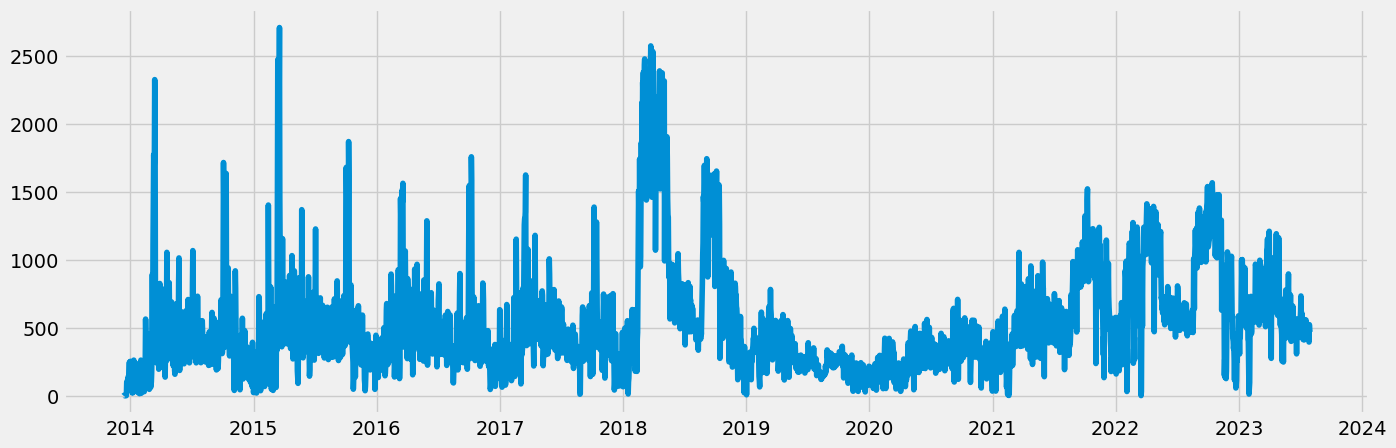

In [5]:
# Plot the data using matplotlib.

plt.figure(figsize=(15,5), dpi=100)

plt.plot(trips)

### there appears to be seasonality from 2013 to 2018 with upward trend after 2020

## 4. Decomposition

In [8]:
# Decompose the time series using an additive model

decomposition = sm.tsa.seasonal_decompose(trips, model='additive', period = 365)

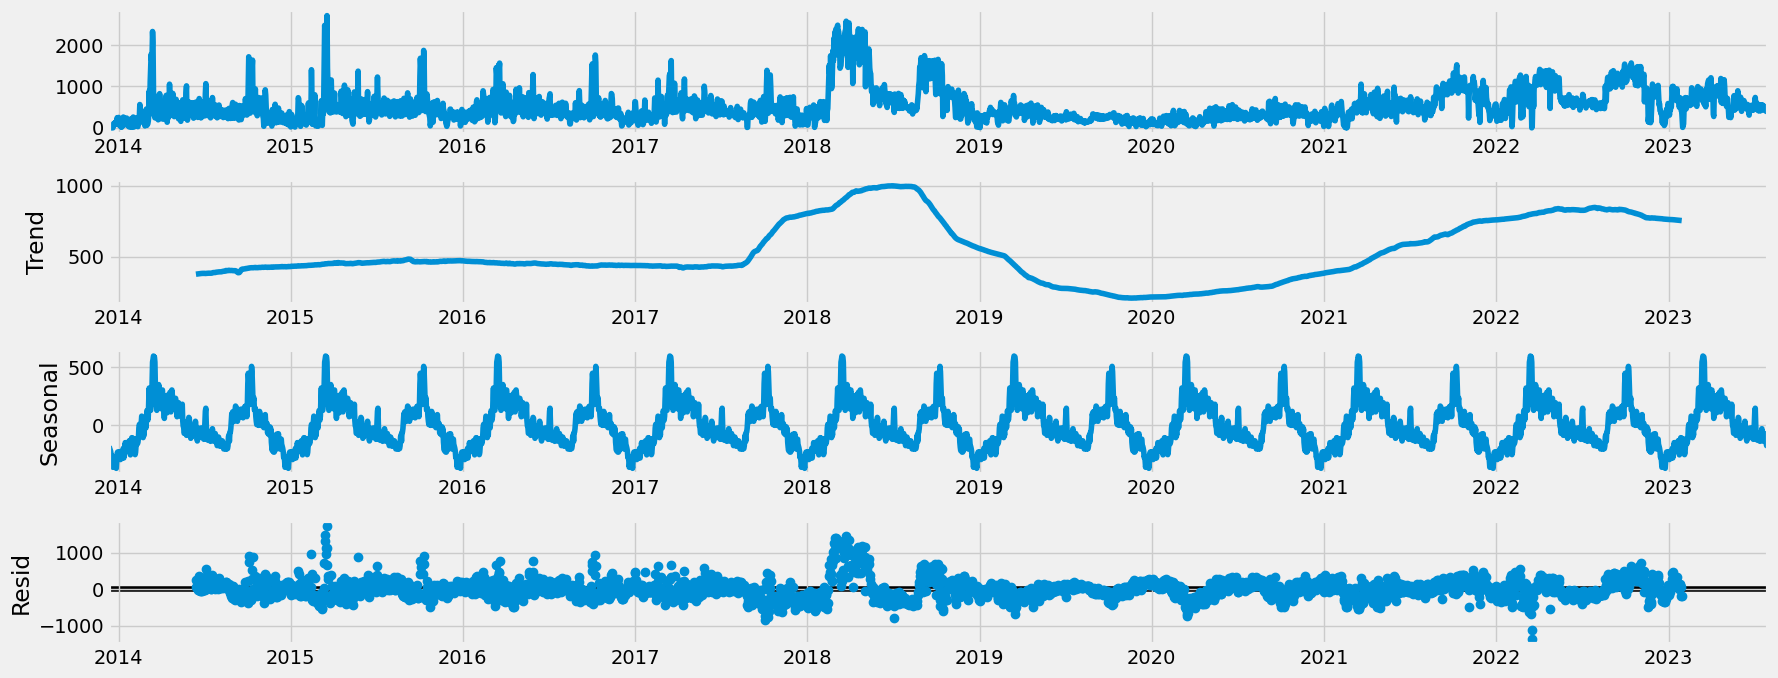

In [9]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7# Plot the separate components

decomposition.plot()
plt.show()

### there isn't a trend from 2013 to late 2017
### there is an upward trend from late 2017 to mid 2018 followed by a downward trend until 2020
### trend is up beginning in 2020
### as suspected there is definite seasonality
### there is some unexplained noise in early 2018

## 5. Conduct Dickey Fuller Test

In [10]:
#import the adfuller() function
from statsmodels.tsa.stattools import adfuller 

#define function
def dickey_fuller(timeseries):
#perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(trips['Trip ID'])

Dickey-Fuller Stationarity test:
Test Statistic                   -4.917436
p-value                           0.000032
Number of Lags Used              29.000000
Number of Observations Used    3486.000000
Critical Value (1%)              -3.432227
Critical Value (5%)              -2.862369
Critical Value (10%)             -2.567212
dtype: float64


### test statistic -4.917 < -2.862 
### we can reject the null hypothesis that there is a unit root
### with no unit root we can say the data is stationary

## 6. Check for autocorrelation

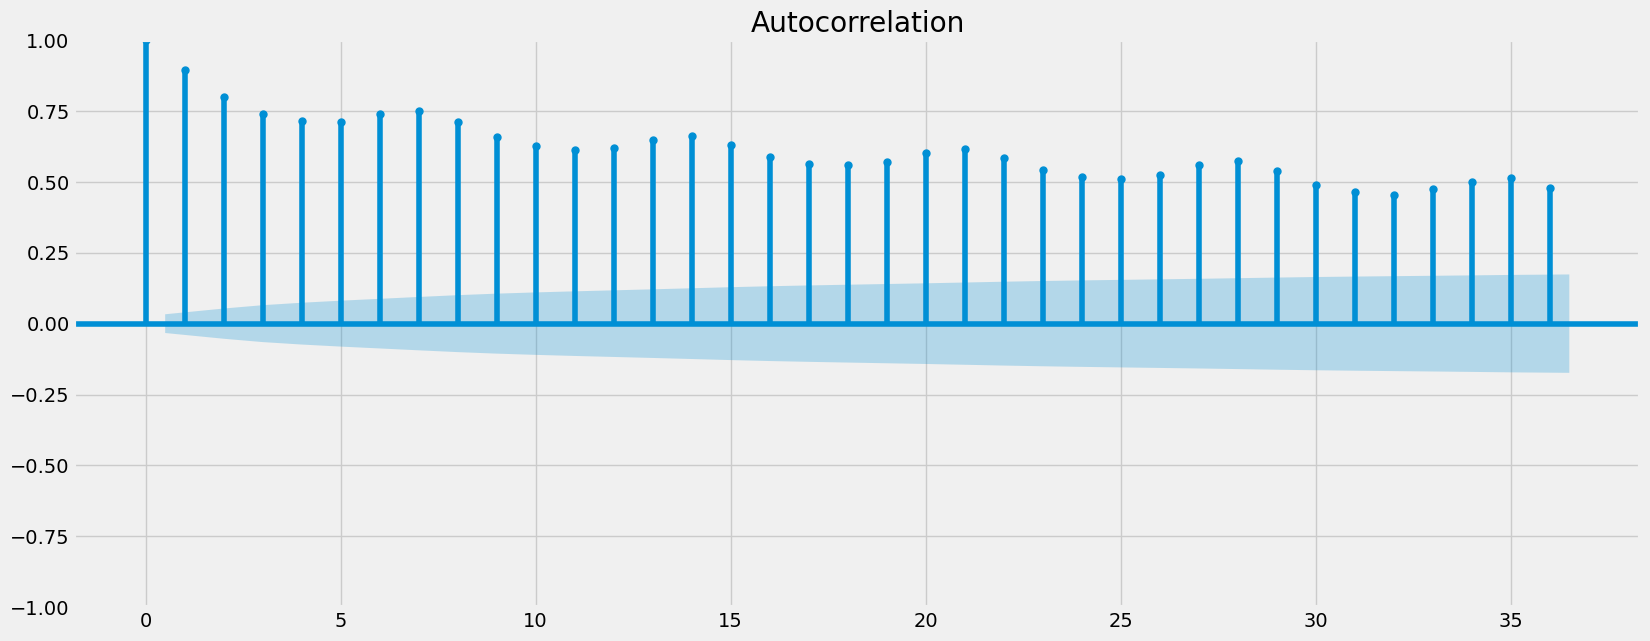

In [11]:
#import the autocorrelation and partial correlation plots
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 

plot_acf(trips)
plt.show()

### all lines are above the confidence interval which means lags are autocorrelated
### suggests data is non-stationary

## 7. Stationarize

In [12]:
#perform differencing
data_diff = trips - trips.shift(1)

In [13]:
#remove missing values from differencing
data_diff.dropna(inplace = True)

In [14]:
data_diff.head()

,Trip ID
Checkout Date,
2013-12-13,3.0
2013-12-15,-3.0
2013-12-17,1.0
2013-12-18,-1.0
2013-12-19,0.0


In [15]:
data_diff.columns

Index(['Trip ID'], dtype='object')

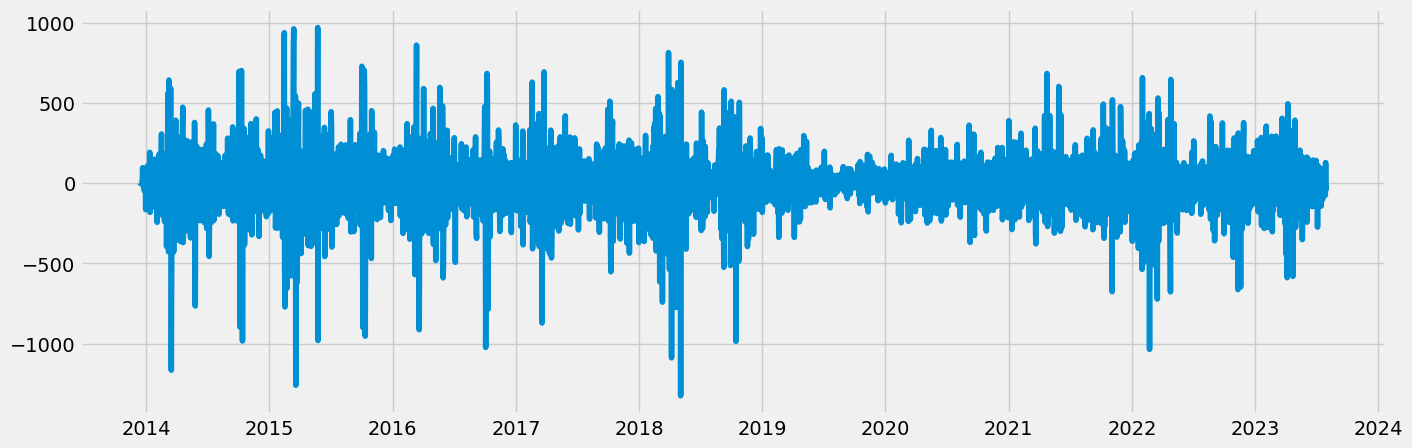

In [16]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [17]:
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                -1.307270e+01
p-value                        1.942270e-24
Number of Lags Used            2.900000e+01
Number of Observations Used    3.485000e+03
Critical Value (1%)           -3.432228e+00
Critical Value (5%)           -2.862370e+00
Critical Value (10%)          -2.567212e+00
dtype: float64


### test statistic is now larger than critical value (-0.13 > -2.86), suggests data is non-stationary

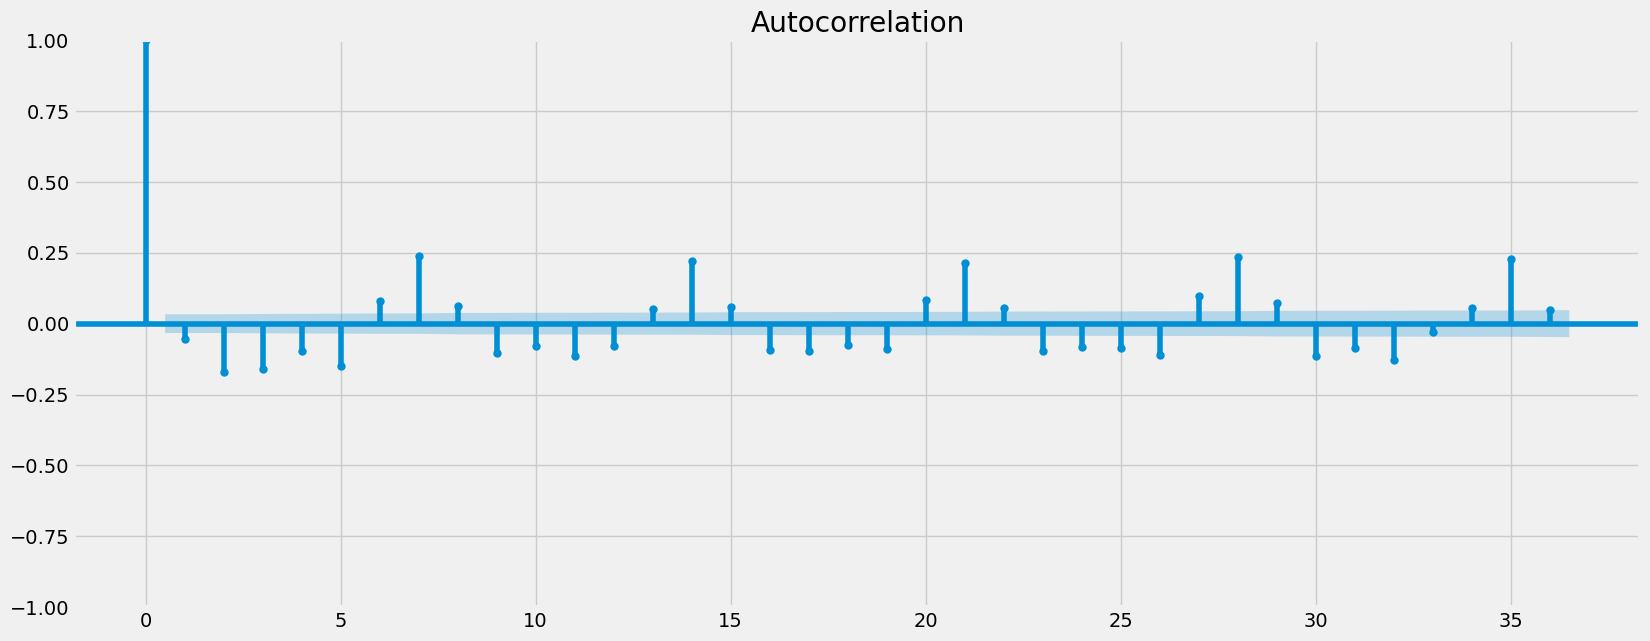

In [18]:
plot_acf(data_diff)
plt.show()

### a few lines are within the confidence interval

## 8. Stationarize again

In [19]:
#perform differencing
data_diff_2 = data_diff - data_diff.shift(1)

In [20]:
#remove missing values from differencing
data_diff_2.dropna(inplace = True)

In [21]:
data_diff_2.head()

,Trip ID
Checkout Date,
2013-12-15,-6.0
2013-12-17,4.0
2013-12-18,-2.0
2013-12-19,1.0
2013-12-20,1.0


In [22]:
data_diff_2.columns

Index(['Trip ID'], dtype='object')

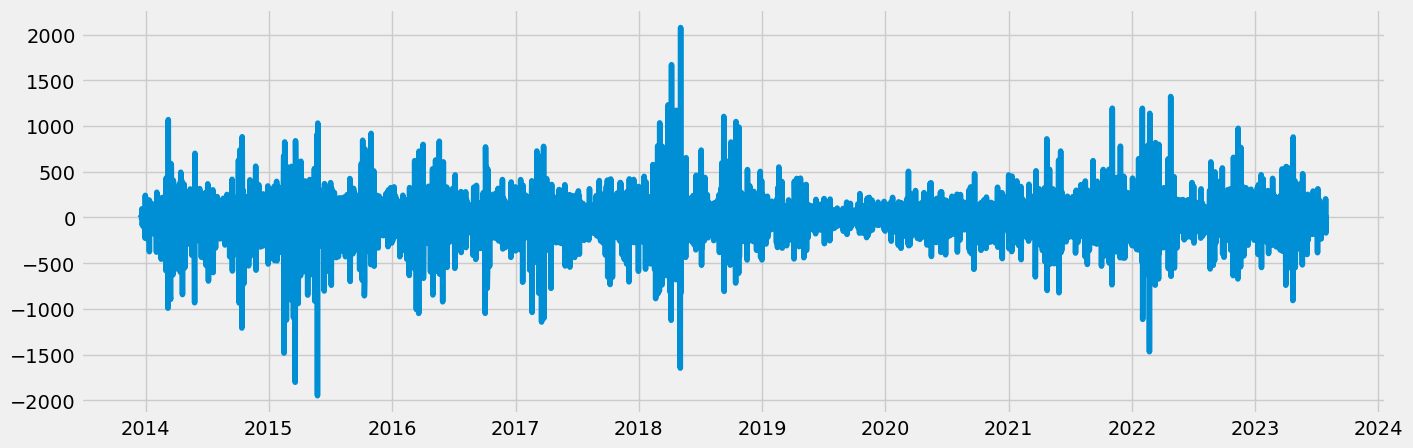

In [23]:
# Check out what second round of differencing did to the time-series curve
plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff_2)

In [24]:
#run dickey fuller test
dickey_fuller(data_diff_2)

Dickey-Fuller Stationarity test:
Test Statistic                  -22.108587
p-value                           0.000000
Number of Lags Used              29.000000
Number of Observations Used    3484.000000
Critical Value (1%)              -3.432228
Critical Value (5%)              -2.862370
Critical Value (10%)             -2.567212
dtype: float64


### test statistic is much smaller than critical value -22.1 < -2.86, suggests stationary

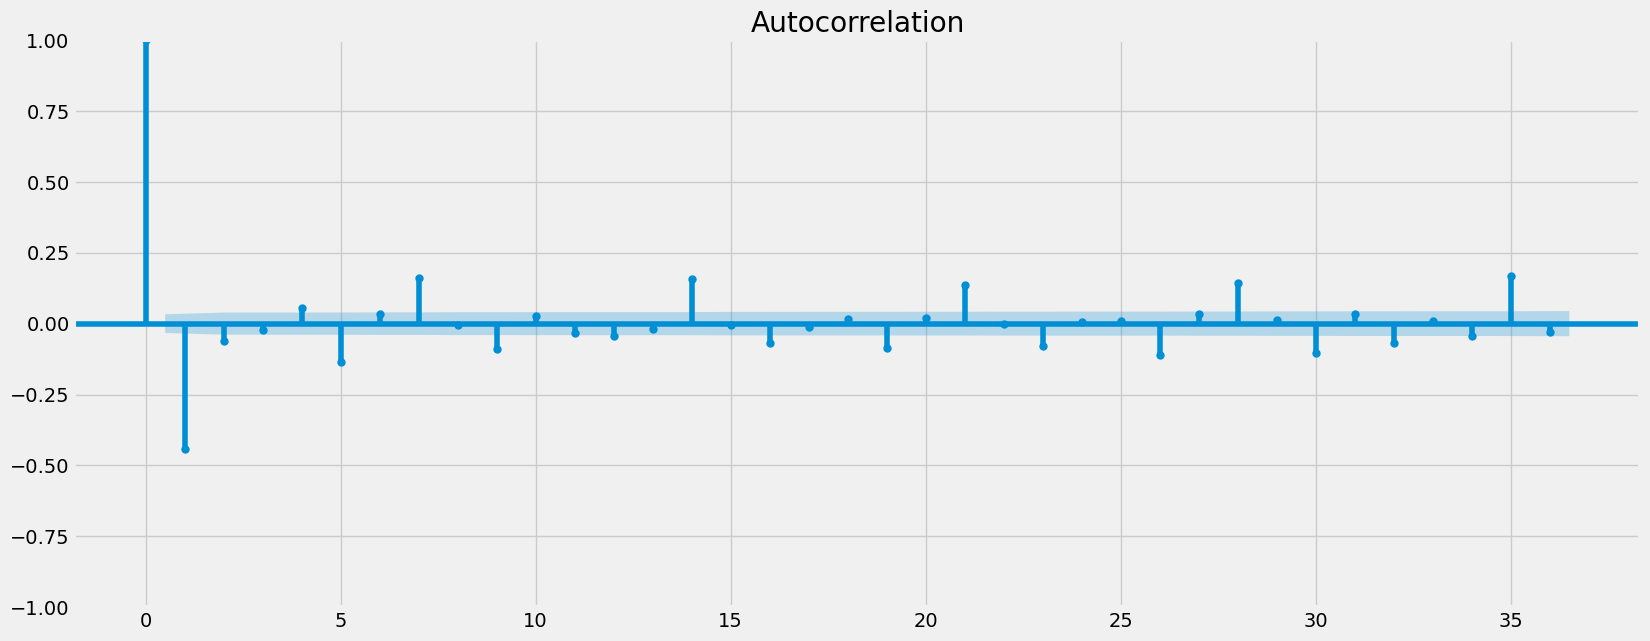

In [25]:
#check for autocorrelation
plot_acf(data_diff_2)
plt.show()

### there are now more bars within the confidence interval

## 9. Stationarize a third time

In [26]:
#perform differencing
data_diff_3 = data_diff_2 - data_diff_2.shift(1)

In [27]:
#remove missing values from differencing
data_diff_3.dropna(inplace = True)

In [28]:
data_diff_3.head()

,Trip ID
Checkout Date,
2013-12-17,10.0
2013-12-18,-6.0
2013-12-19,3.0
2013-12-20,0.0
2013-12-21,94.0


In [29]:
data_diff_3.columns

Index(['Trip ID'], dtype='object')

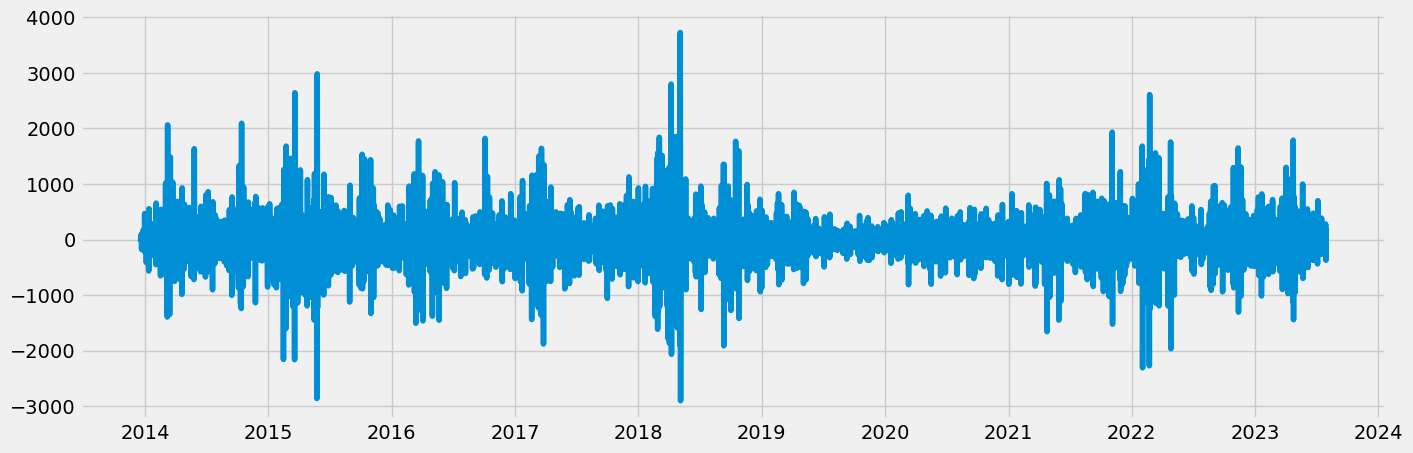

In [30]:
# Check out what second round of differencing did to the time-series curve
plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff_3)

In [31]:
#run dickey fuller test
dickey_fuller(data_diff_3)

Dickey-Fuller Stationarity test:
Test Statistic                  -26.313979
p-value                           0.000000
Number of Lags Used              30.000000
Number of Observations Used    3482.000000
Critical Value (1%)              -3.432229
Critical Value (5%)              -2.862370
Critical Value (10%)             -2.567212
dtype: float64


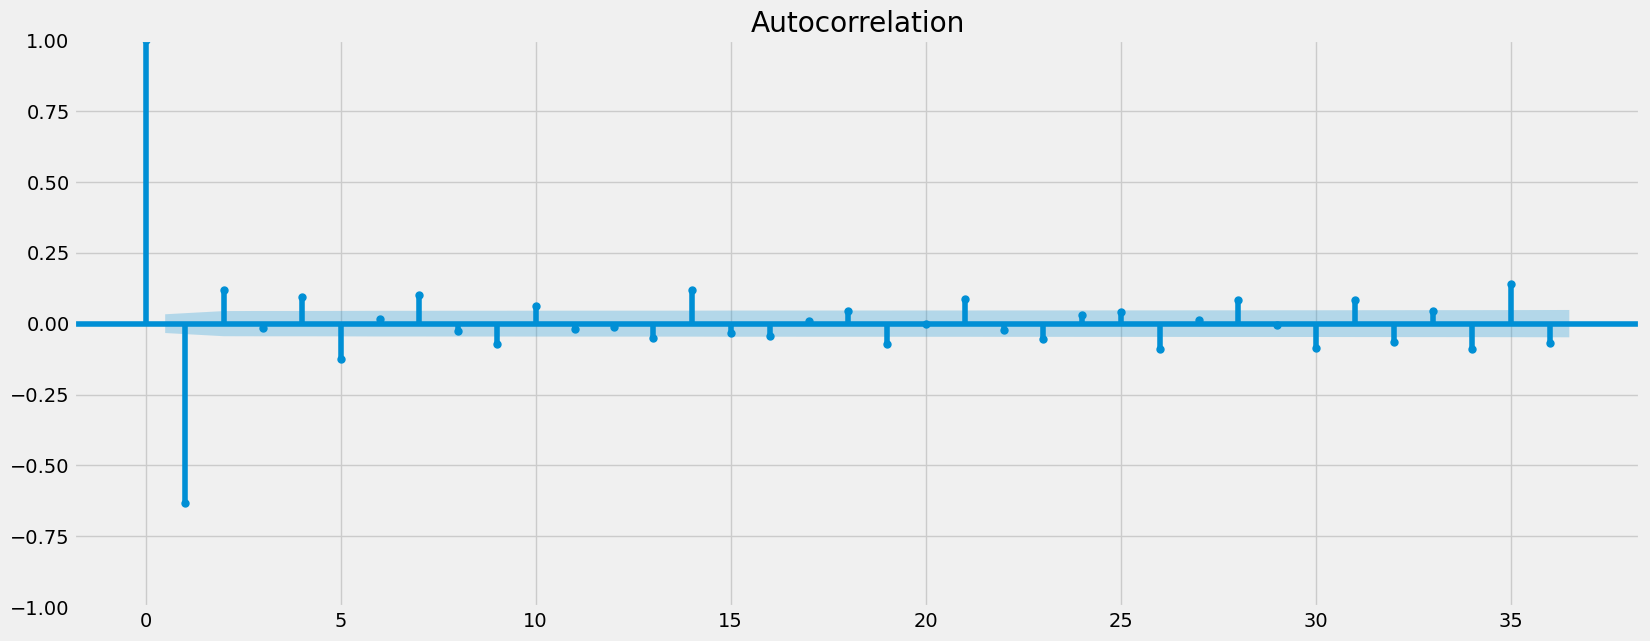

In [32]:
#check for autocorrelation
plot_acf(data_diff_3)
plt.show()